In [90]:
!pip install keras-rl2 tf-agents
# !pip install --upgrade 

In [91]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from gym.envs.registration import register

# math packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
import math

# openai packages
from gym import Env
from gym.spaces import Discrete, Tuple

# Neural network packages
import tensorflow as tf
from tensorflow import keras
from keras import models, layers


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# system packagse
import os
import sys
import time

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tictactoe-win-movement/tictactoe_win_movement.csv


# 1. I create the Tic tac toe class and the base configuration of the player

In [92]:
class TicTacToe(Env):
    metadata = {
        "render_modes": [
            "human"
        ],
        "render_fps": 4
    }
    secondTransform = np.flip(np.identity(3), axis=1)
    
    def __init__(self, numOfPlayers: int, table: np.matrix, lengthOfLine: int, allowDebug: bool):
        # self.pointUpdated = np.zeros(2) # 0: field, 1 col
        # self.player = 0
        
        self.fields = table.shape[0]
        self.cols = table.shape[1]
        
        # define personalized environment gym props
        self.table = table # has a state role 
        
        #self.action_space = Tuple((Discrete(self.fields), Discrete(self.cols))) # for delete tuples used after
        self.action_space = Discrete(self.fields * self.cols) # for delete tuples used after
        
        # self.action_space = Box(low=-1.0, high=2.0, shape=(self.fields, self.cols), dtype=np.float32)
        #self.action_space.sample()
        
        # self.reset(fillTable=False)
        
        self.lengthOfLine = lengthOfLine
        self.numOfPlayers = numOfPlayers
        self.redirectToChange(allowDebug)
        
    def redirectToChange(self, allowDebug):
        self.redirectPrintTo = sys.stdout

        if not allowDebug:
            self.redirectPrintTo = open(os.devnull, 'w')
    
    def add_players(self, players):
        self.numOfPlayers = len(players)
        self.players = players

    def _get_obs(self):
        return self.table.reshape((1, 9)).tolist()[0]
        # return tf.convert_to_tensor(
        #  [self.table.reshape((1,9)).tolist()],
        #  dtype=tf.int32
        #)
        
    def _get_info(self):
        return {
            "status": None
        }
    
    def reset(self):
        self.table.fill(0)
        self.time = 0
        self.winner = 0
        self.turn = random.choices([1, self.numOfPlayers])[0]

        self.history = tf.Variable(tf.zeros(shape=(self.fields * self.cols + 1, self.fields, self.cols), dtype=tf.dtypes.int32))
        self.saveToHistory()
      
        #return tf.convert_to_tensor(
        #  [self.table.reshape((1,9)).tolist()],
        #  dtype=tf.int32
        #)
        return self.table.reshape((1, 9)).tolist()[0]

    def __deepcopy__(self, memodict={}):
        cpyobj = type(self)() # shallow copy of whole object 
        cpyobj.deep_cp_attr = copy.deepcopy(self.other_attr, memodict) # deepcopy required attr

        return cpyobj
    
    def saveToHistory(self):
        self.history[self.time].assign(self.table)
        self.time += 1 
            
    def changeTurn(self):
        if self.turn < self.numOfPlayers:
            self.turn = self.turn + 1
        else:
            self.turn = 1

    def hasOwner(self, field: int, col: int):
        return self.table.item(field, col) != 0
 

    def crossOutCell(self, field: int, col: int, idPlayer: int) -> bool:        
        if field < self.table.shape[0] and \
            col < self.table.shape[1] and 0 <= field and 0 <= col:
            if not self.hasOwner(field, col):
                if self.turn == idPlayer:
                    self.table.itemset((field, col), self.turn)
                    self.saveToHistory()
                    self.changeTurn()
        else:
              print("invalid input", file=self.redirectPrintTo)
        return False

    def headerTable(self, players):
        print(str(self.turn) + ", wait for checking to play", file=self.redirectPrintTo)
        if players != None:
            for player in players:
                print(str(player.idPlayer)+":" + player.name, file=self.redirectPrintTo)
        print("", file=self.redirectPrintTo)

    def formatTable(self, players, showHeader: bool = False):
        if showHeader:
              self.headerTable(players)
        for f in range(0, self.table.shape[0]):
            for c in range(0, self.table.shape[1]):
                print(self.table.item(f, c), end=" ", file=self.redirectPrintTo)
            print("", file=self.redirectPrintTo)

    def finishedGame(self) -> bool:
        for f in range(0, self.table.shape[0]):
            for c in range(0, self.table.shape[1]):
                if self.table.item(f, c) == 0:
                    return False
        self.winner = -1
        return True

    def findWinnerAtDiag(self, table: np.matrix) -> int:
        for f in range(0, table.shape[0]):
          #  -table.shape[0]+1 is the last principal diagonal of field
          #  table.shape[1]-1 is the last principal diagonal of cols
          # self.lengthOfLine 
          for numDiag in range(-table.shape[0]+1, table.shape[1]-1):
            diag = np.diag(table, k=numDiag)
            if self.lengthOfLine <= diag.shape[0]:
                player = self.findWinnerAtfields(np.matrix(diag))
                if player != 0:
                    return player
        return 0
  
    def findWinnerAtfields(self, table: np.matrix, redirect=sys.stdout) -> int:
        countOfLine=0
        player=0
        weHaveAWinner=False

        # self.formatTable(table)
        for f in range(0, table.shape[0]):
            player=0
            countOfLine=0

            for c in range(0, table.shape[1]):
                cell = table.item(f, c)
                # print(cell, end=" ")
                if cell == 0:
                    countOfLine=0
                    player=0
                else:
                    if player == cell:
                        countOfLine+=1
                    else:
                        player=cell
                        countOfLine=1
                    if countOfLine == self.lengthOfLine:
                        weHaveAWinner=True
                        break
            # print("")
            if weHaveAWinner:
                break
        if weHaveAWinner:
            return player
        return 0

    def checkWinnerAt(self, findWinnerAt, table, foundMessage):
        winnerAt = findWinnerAt(table) # find winner at function passed
        if winnerAt == 0:
            return False
        else:
            self.winner = winnerAt
            print(foundMessage+ " " + str(winnerAt), file=self.redirectPrintTo)
            return True
    
    def checkIfWinner(self) -> bool:
        print("...checking...", file=self.redirectPrintTo)
        
        # check cols and fields
        return self.checkWinnerAt(self.findWinnerAtfields, self.table, "we have a fields winner!!!,") \
            or self.checkWinnerAt(self.findWinnerAtfields, self.table.transpose(), "we have a cols winner!!!,") \
            or self.checkWinnerAt(self.findWinnerAtDiag, self.table, "we have a principal diagonal winner!!!,") \
            or self.checkWinnerAt(self.findWinnerAtDiag, self.table.dot(TicTacToe.secondTransform), "we have a secondary diagonal winner!!!,")
    
    def scalar_to_action(self, scalar):
        maxField = self.fields
        maxCols = self.cols
        
        field = math.floor(scalar/maxField)
        cols = scalar % maxCols
        
        return (field, cols)
    
    # def step(self, action, idPlayer: int, players):
    def step(self, action):
        # check if you have new points to use
        self.finishedGame()
        self.checkIfWinner()

        if self.winner == 0:
            if type(action) == tuple:
                self.crossOutCell(action[0], action[1], self.turn)
            elif type(action) == int or type(action) == np.int64:
                new_action = self.scalar_to_action(action)
                self.crossOutCell(new_action[0], new_action[1], self.turn)
            else:
                print("action type error")
                print(type(action))

            self.finishedGame()
            self.checkIfWinner()
            
        return self.getReward(self.turn)
    
      
    def getReward(self, idPlayer):
        reward = 0
        done = False
        info  = {
          "status": "Playing...",
          "winner": 0
        }
                  
        if self.winner != 0:
            if self.winner == -1:
                reward = 0
                done=True
                info = {
                  "status": "We dont have a winner, draw :(",
                  "winner": self.winner
                }

            elif self.winner == idPlayer:
                reward = 1
                done=True
                info = {
                  "status": "You win!",
                  "winner": self.winner
                }
            elif self.winner != idPlayer:
                reward = -1
                done=True
                info = {
                  "status": "You lose",
                  "winner": self.winner
                }
            else:
                print("unknown winner option")

            
        return self.table.reshape((1, 9)).tolist()[0], reward, done, info
    
    def render(self, players=None, mode=None):
        if mode == "human":
            self.formatTable(players, showHeader=True) 
        
    def run_episode(self): # before def invoke
        done = False
        counter = 0
        while not done and counter < 100:
            
            # - 1 because the user of turn 0 doesnt exist
            player = self.players[self.turn - 1]
            
            # render game 
            self.render(self.players, mode="human")
 
            player.play(self.players, tictactoe=self)
            n_state, reward, done, info = self.getReward(player.idPlayer)
       
            counter+=1
        
        self.render(self.players, mode="human")

        # tells all users who wins
        for player in self.players:
            n_state, reward, done, info = self.getReward(player.idPlayer)
            player.save(n_state, reward, done, info)
            
            player.showDescription(self.redirectPrintTo)
            
#register(
#    id='gym_examples/tictactoe',
#    entry_point='gym_examples.envs:tictactoe',
#    max_episode_steps=300,
#)

Next i add all logic. First at all Player class:

In [93]:
class Player:
    def __init__(self, idPlayer: int, name: str):
        if name == "":
              self.name = input("Player insert your name:")
        self.name = name
        self.idPlayer = idPlayer
        self.n_state = None
        self.reward = None
        self.done = False
        self.info = None
        
    def play(self, players, tictactoe, action=None):
        field = 0
        column = 0
        if not self.done:
            if action == None:
                field = int(input('Enter field:'))
                column = int(input('Enter column:'))
            else:
                field = action[0]
                cols = action[1]
        n_state, reward, done, info = tictactoe.step((field, column))

        self.save(n_state, reward, done, info)
    
    def save(self, n_state, reward, done, info):
        self.n_state = n_state
        self.reward = reward
        self.done = done
        self.info = info
        
    def showResults(self):
        return self.n_state, self.reward, self.done, self.info
    
    def showDescription(self, redirectPrintTo):
        print('id:{} State:{} Reward:{} Done:{} Info:{}'.format(self.idPlayer, self.n_state, self.reward, self.done, self.info), file=redirectPrintTo)

    def getPlayer(self):
        return self

now we add random AI

In [94]:
# deprecated: AI_Reinforcement_Random remplace it
class AIRandom(Player):
    def __init__(self, idPlayer: int, name: str):
        super().__init__(idPlayer, name)
 
    def play(self, players, tictactoe):
        action = (np.random.randint(0, tictactoe.fields), np.random.randint(0, tictactoe.cols))
        n_state, reward, done, info = tictactoe.step(action)

        self.save(n_state, reward, done, info)
     

Ai reinforcement with openai gym package config

In [95]:
class AI_Reinforcement_Random(Player):
    def __init__(self, idPlayer: int, name: str):
        super().__init__(idPlayer, name)
        self.score = 0
        # self.episode=1

    def play(self, players, tictactoe):
        # tictactoe.render(players)

        action = tictactoe.action_space.sample()

        n_state, reward, done, info = tictactoe.step(action)
        
        self.save(n_state, reward, done, info)

    def showDescription(self, redirectPrintTo):
        print('id:{} Episode:{} Reward:{} Info:{}'.format(self.idPlayer, 1, self.reward, self.info), file=redirectPrintTo)


i create a automated playing function

In [96]:
def playTwoPlayers(
        player1,
        player2,
        allowDebug=False,
        # start at one because 0 represent an empty cell and should be positive integers 
        tictactoe = TicTacToe(2, np.zeros((3, 3), np.int32), 3, False)
    ):
    
    tictactoe.redirectToChange(allowDebug)
    #tictactoe = TicTacToe(2, np.array([
    #    [2, 1, 2],
    #    [1, 1, 0],
    #    [2, 2, 1]
    #], np.int32), 3, allowDebug)
    tictactoe.add_players([player1, player2])
    tictactoe.reset()
    tictactoe.run_episode()
    
    return [ tictactoe.history, tictactoe.winner]
    

Now we put them to compete and see the odds of winning, losing and drawing. Using the following function

In [97]:
def createPlot(historyAndWinner, winnerAtitle, winnerBtitle, redirect=open(os.devnull, 'w'), num_of_games=300):
    batch = 10
    number_that_divides_list = num_of_games / batch

    winnerAList = np.zeros(shape=batch, dtype=float)
    drawList = np.zeros(shape=batch, dtype=float)
    winnerBList = np.zeros(shape=batch, dtype=float)

    num_played = 0

    winnerA= 0
    draw = 0
    winnerB= 0

    for i in range(0, num_of_games):
        history, winner = historyAndWinner()
        
        # add probabilities points to winnerA, draw and winnerB 
        if winner == 1:
            winnerA = winnerA + 1
        elif winner == 2:
            winnerB = winnerB + 1
        else:
            draw = draw + 1

        # save proxination
        if num_played % number_that_divides_list == 0 and num_played != 0:
            pos = int(num_played/number_that_divides_list)

            winnerAList.itemset(pos, winnerA/num_played)
            drawList.itemset(pos, draw/num_played)
            winnerBList.itemset(pos, winnerB/num_played)

            print(str(num_played) + "/" + str(num_of_games) + " games", file=redirect)
        num_played = num_played + 1
    
    
    x = np.linspace(batch, num_of_games, batch)
    y= np.ones(batch)
    
    plt.figure(figsize=(13, 9))
    plt.title("Probabilities for " + winnerAtitle + " vs " + winnerBtitle)
    
    plt.xlabel("games") 
    plt.ylabel("probability")
    
    plt.plot(x, winnerAList, 'r', label=winnerAtitle)
    plt.plot(x, drawList, 'g', label="draw")
    plt.plot(x, winnerBList, 'b', label=winnerBtitle)
    
    plt.plot(x, winnerAList[batch-1]*y, 'r', label='limit ' + winnerAtitle + ': ' + str(winnerAList[batch-1]))
    plt.plot(x, drawList[batch-1]*y, 'g', label='limit draw ' + str(drawList[batch-1]))
    plt.plot(x, winnerBList[batch-1]*y, 'b', label='limit ' + winnerBtitle + ': ' + str(winnerBList[batch-1]))
    
    plt.legend(loc='upper left')
    
    plt.show()

# createPlot(historyAndWinner=playTwoPlayers, title="AI Random vs Random")
# createPlot(historyAndWinner=playAIRandomVSReinforcement, title="AI Random vs AI_Reinforcement_Random")
# createPlot(historyAndWinner=playReinforcementVSReinforcement, title="AI_Reinforcement_Random vs AI_Reinforcement_Random")


13/130 games
26/130 games
39/130 games
52/130 games
65/130 games
78/130 games
91/130 games
104/130 games
117/130 games


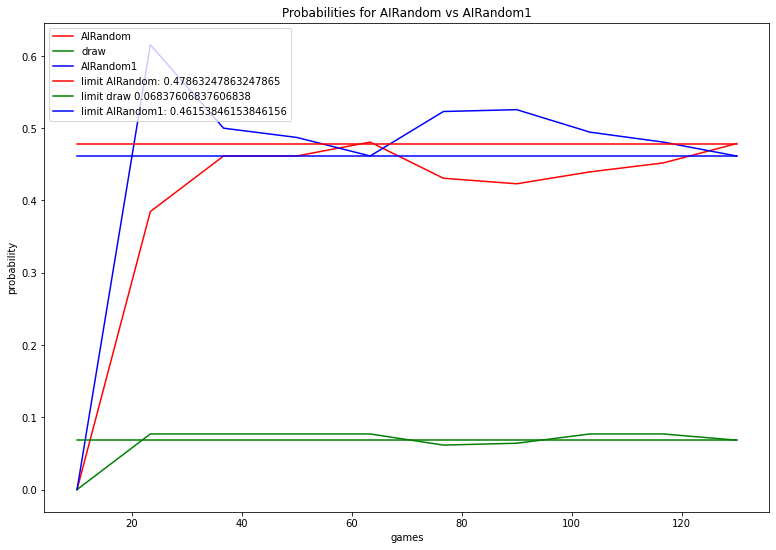

In [98]:
createPlot(
    lambda: playTwoPlayers(
        AIRandom(1, "AIRandom"),
        AIRandom(2, "AIRandom1"),
    ),
    "AIRandom",
    "AIRandom1",
    redirect=sys.stdout,
    num_of_games=130
)

20/200 games
40/200 games
60/200 games
80/200 games
100/200 games
120/200 games
140/200 games
160/200 games
180/200 games


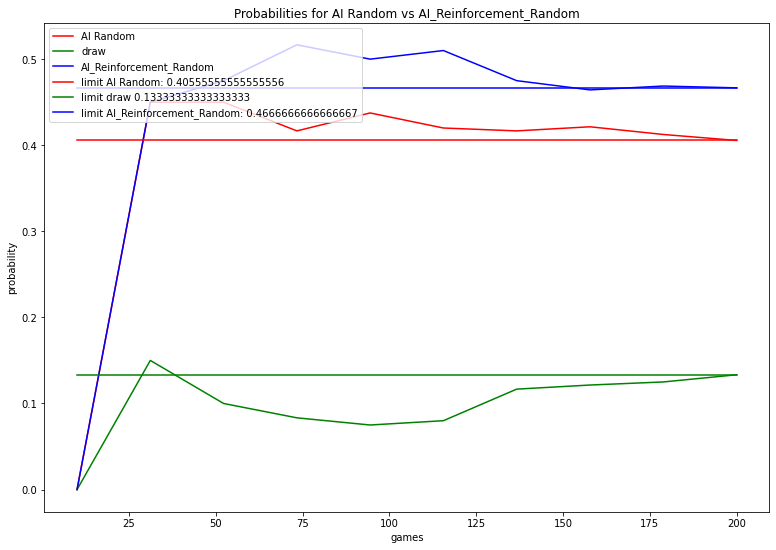

In [99]:
createPlot(
    lambda: playTwoPlayers(
        AIRandom(1, "AI Random"),
        AI_Reinforcement_Random(2, "AI_Reinforcement_Random"),    
    ),
    "AI Random",
    "AI_Reinforcement_Random",
    redirect=sys.stdout,
    num_of_games=200
)

13/130 games
26/130 games
39/130 games
52/130 games
65/130 games
78/130 games
91/130 games
104/130 games
117/130 games


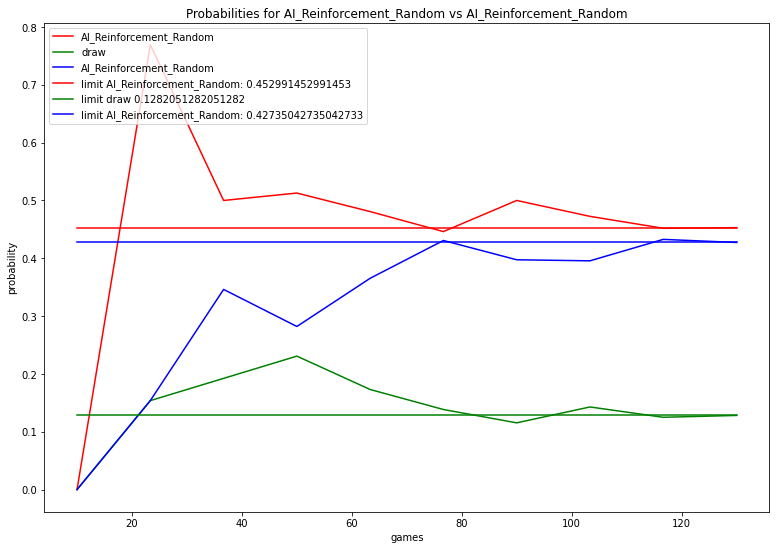

In [100]:
createPlot(
    lambda: playTwoPlayers(
        AI_Reinforcement_Random(1, "AI_Reinforcement_Random"),
        AI_Reinforcement_Random(2, "AI_Reinforcement_Random"),   
    ),
    "AI_Reinforcement_Random",
    "AI_Reinforcement_Random",
    redirect=sys.stdout,
    num_of_games=130
)

look how bad he plays and play against him

In [101]:
history, winner = playTwoPlayers(
    AI_Reinforcement_Random(1, "AI_Reinforcement_Random1"),
    AI_Reinforcement_Random(2, "AI_Reinforcement_Random2"),
    allowDebug=True
)

1, wait for checking to play
1:AI_Reinforcement_Random1
2:AI_Reinforcement_Random2

0 0 0 
0 0 0 
0 0 0 
...checking...
...checking...
2, wait for checking to play
1:AI_Reinforcement_Random1
2:AI_Reinforcement_Random2

0 0 1 
0 0 0 
0 0 0 
...checking...
...checking...
1, wait for checking to play
1:AI_Reinforcement_Random1
2:AI_Reinforcement_Random2

0 0 1 
0 0 2 
0 0 0 
...checking...
...checking...
1, wait for checking to play
1:AI_Reinforcement_Random1
2:AI_Reinforcement_Random2

0 0 1 
0 0 2 
0 0 0 
...checking...
...checking...
2, wait for checking to play
1:AI_Reinforcement_Random1
2:AI_Reinforcement_Random2

1 0 1 
0 0 2 
0 0 0 
...checking...
...checking...
1, wait for checking to play
1:AI_Reinforcement_Random1
2:AI_Reinforcement_Random2

1 0 1 
0 0 2 
0 0 2 
...checking...
...checking...
we have a fields winner!!!, 1
2, wait for checking to play
1:AI_Reinforcement_Random1
2:AI_Reinforcement_Random2

1 1 1 
0 0 2 
0 0 2 
id:1 Episode:1 Reward:1 Info:{'status': 'You win!', 'wi

In [102]:
try:
    playTwoPlayers(
        Player(1, "Me"),
        AI_Reinforcement_Random(2, "Reinforcement"),
        allowDebug=True

    )
except:
    print("input error")

1, wait for checking to play
1:Me
2:Reinforcement

0 0 0 
0 0 0 
0 0 0 


Enter field: 1
Enter column: 1


...checking...
...checking...
2, wait for checking to play
1:Me
2:Reinforcement

0 0 0 
0 1 0 
0 0 0 
...checking...
...checking...
2, wait for checking to play
1:Me
2:Reinforcement

0 0 0 
0 1 0 
0 0 0 
...checking...
...checking...
2, wait for checking to play
1:Me
2:Reinforcement

0 0 0 
0 1 0 
0 0 0 
...checking...
...checking...
1, wait for checking to play
1:Me
2:Reinforcement

0 0 0 
0 1 0 
2 0 0 


Enter field: 0
Enter column: 


input error


# 2. I create a class that makes its own decisions with a neural network

In [103]:
from tensorflow import keras
from keras import losses, metrics, optimizers

from keras.models import Sequential
from keras.layers import MaxPooling2D, \
    Dropout, \
    Dense, \
    Flatten, \
    Convolution2D as Conv2D, \
    Reshape
from keras.utils.vis_utils import plot_model

from tensorflow.keras.optimizers import SGD
import pandas as pd
from pandas import DataFrame

from pathlib import Path
from IPython.display import Image

Note: AIBestDecision in Version 17 has been trained with a random player, therefore winner prediction are too random (the win prediction of both are 0, verified in practice). Hence try to predict the winner is a bad strategy. Now,
try instead of making a prediction, I predict the best option straight

In [104]:
class AIBestDecision(AI_Reinforcement_Random):
    _aiBestDecision = None
    
    def __init__(self, idPlayer: int, name: str, \
            datasetFile = '/kaggle/input/tictactoe-win-movement/tictactoe_win_movement.csv', \
            datasetFileUpdates = '/kaggle/working/tictactoe_win_movement.csv', \
            build=True
                ):
        super().__init__(idPlayer, name)
        

        self.inputTable = []
        self.prob_choose = []
        self.turn_choose  = []
        self.next_table = []
        self.network = None
        self.initialized = False

        self.metrics = None
        self.datasetFile = datasetFile
        self.datasetFileUpdates = datasetFileUpdates

        self.numOfGames = 0
        self.initial_structure(build)
        
    def Singleton(idPlayer: int = -1, name: str = "example", \
            datasetFile = '/kaggle/input/tictactoe-win-movement/tictactoe_win_movement.csv', \
            datasetFileUpdates = '/kaggle/working/tictactoe_win_movement.csv', \
            build=True
                ):
        if AIBestDecision._aiBestDecision == None:
            AIBestDecision._aiBestDecision = AIBestDecision(
                idPlayer,
                name,
            #    tictactoe,
                datasetFile,
                datasetFileUpdates,
                build
            )
        agent = AIBestDecision(
            idPlayer,
            name,
        #    tictactoe,
            datasetFile,
            datasetFileUpdates,
            False
        )
        agent.network = AIBestDecision._aiBestDecision.network
        
        return agent
        
    def initial_structure(self, build):
        
        if not self.initialized and build:
            
            # create dataset file
            self.createDataset()

            # create data
            self.collect()
                        
            # save already created data
            self.saveToDataset()
            
            # get already saved data
            self.getDataset()
            
            # create model, compile and fit
            self.model()
            self.compileNetwork()
            self.fit()
            
            self.initialized = True
        
    def swap_id_player_in_table(self, arr, idplayerWinner, idPlayerLooser):
        arrAux = np.matrix(arr)
        
        np.place(arrAux, arrAux == idplayerWinner, -idplayerWinner)
        np.place(arrAux, arrAux == idPlayerLooser, idplayerWinner)
        np.place(arrAux, arrAux == -idplayerWinner, idPlayerLooser)
    
        return arrAux
    
    def collect(self):
        for idGame in range(0, self.numOfGames):
            # history, rewardsPerUser = self.randomPlay()
            history, winner = self.randomPlay()
            length_of_history = len(history.numpy())

            for i in range(0, length_of_history - 1):

                tableBefore = np.matrix(history[i])
                tableAfter = np.matrix(history[i+1])

                # if tableAfter is not zero, T != 0
                if not np.equal(tableAfter, np.zeros((3,3))).all():

                    tableChange = (tableAfter - tableBefore)

                    # 1/self.idPlayer normalze the matrix ( all 0 or 1)
                    turn = tableChange.sum()
                    tableChangeNormalized = (1/turn) * tableChange

                    # If the winner plays and he is not me, do roles reverse.
                    # that is instead of ignoring 
                    if winner != 1:
                        
                        # learn from the rival decisions
                        tableBefore = self.swap_id_player_in_table(tableBefore, winner, 1)
                        tableAfter= self.swap_id_player_in_table(tableAfter, winner, 1)
                        
                    # if win, draw or lose in the actual table, too in identity table
                    self.inputTable.append(tableBefore)
                    self.prob_choose.append(tableChangeNormalized)
                    self.turn_choose.append(turn)
                    self.next_table.append(tableAfter)
    
                    # if win, draw or lose in the actual table, too in table transpose
                    self.inputTable.append(tableBefore.copy().transpose())
                    self.prob_choose.append(tableChangeNormalized.copy().transpose())
                    self.turn_choose.append(turn)
                    self.next_table.append(tableAfter.copy().transpose())
                    
                    # if win, draw or lose in the actual table, too in table flip 
                    self.inputTable.append(tableBefore.copy().dot(TicTacToe.secondTransform))
                    self.prob_choose.append(tableChangeNormalized.copy().dot(TicTacToe.secondTransform))
                    self.turn_choose.append(turn)
                    self.next_table.append(tableAfter.copy().dot(TicTacToe.secondTransform))
                    
                    
                    # if win, draw or lose in the actual table, too in transpose and flips
                    
                    self.inputTable.append(
                        tableBefore.copy()
                            .dot(TicTacToe.secondTransform)
                            .transpose()
                    )
                    self.prob_choose.append(
                        tableChangeNormalized.copy()
                            .dot(TicTacToe.secondTransform) 
                            .transpose()
                    )
                    self.turn_choose.append(turn)
                    self.next_table.append(
                        tableAfter.copy()
                            .dot(TicTacToe.secondTransform)
                            .transpose()
                    )
                    
                    
    def createDataset(self):
        # /kaggle/working
        # if not Path(self.datasetFileUpdates).is_file():
        csvBestDecision = DataFrame(data=None, index=None, columns=["table", "table_prob_choose", "turn_choose", "next_table"] ,dtype=None, copy=None)
        csvBestDecision.to_csv(self.datasetFileUpdates, index=None) # save to notebook output
            
    def getDataset(self):
        csvBestDecision = pd.read_csv(self.datasetFile) # load from notebook input
        
        self.inputTable = csvBestDecision["table"].to_list()
        self.prob_choose =  csvBestDecision["table_prob_choose"].to_list()
        self.turn_choose =  csvBestDecision["turn_choose"].to_list()
        
        for i in range(0, len(self.inputTable)):
            # tableAux = np.matrix(AIBestDecision.inputTable[i], dtype= np.int32)
            # prob_choose_aux = np.matrix(AIBestDecision.prob_choose[i], dtype=np.int32)

            self.inputTable[i] = np.reshape(
                np.matrix(self.inputTable[i], dtype= np.int32),
                (3, 3)
            )
            self.prob_choose[i] = np.reshape(
                np.matrix(self.prob_choose[i], dtype=np.int32),
                (1, 9)
            )
            
        self.inputTable = np.array(self.inputTable)
        self.prob_choose =  np.array(self.prob_choose)
        self.turn_choose =  np.array(self.turn_choose)

        # AIBestDecision.inputTable = tf.convert_to_tensor(AIBestDecision.inputTable)
        # AIBestDecision.prob_choose =  tf.convert_to_tensor(AIBestDecision.prob_choose)
        
        print("Data size: " + str(len(csvBestDecision["table_prob_choose"])))
        
    def saveToDataset(self):
        data = {
            'table': self.inputTable,
            'table_prob_choose': self.prob_choose,
            "turn_choose": self.turn_choose,
            "next_table": self.next_table
        }
                
        # Make data frame of above data
        df = pd.DataFrame(data)
 
        # append data frame to CSV file
        df.to_csv(self.datasetFileUpdates, mode='a', header=False, index=False)
        
    def play(self, players, tictactoe):
        table = tictactoe.table.copy()
        action = (0, 0)
        probToWin = 0
        
        # adapt the table to the train data
        if self.idPlayer != 1:
            table = self.swap_id_player_in_table(table, self.idPlayer, 1)
            
        predict = self.network.predict(np.array(table).reshape(
            (1, tictactoe.fields, tictactoe.cols)
        )).reshape((tictactoe.fields, tictactoe.cols))
        
        for f in range(0, tictactoe.fields):
            for c in range(0, tictactoe.cols):
                
                # search empty spaces in the table 
                if table.item(f,c) == 0:
                    
                    # search best option
                    if probToWin < predict.item(f, c):
                        probToWin = predict.item(f, c)
                        action = (f, c)
                        
        n_state, reward, done, info = tictactoe.step(action)
        
        self.save(n_state, reward, done, info)
        
    def randomPlay(self):
        # Player

        player1 = AI_Reinforcement_Random(1, "Train1", tictactoe)
        player2 = AI_Reinforcement_Random(2, "Train2", tictactoe)

        tictactoe = TicTacToe(2, np.zeros((3, 3), np.int32), 3, allowDebug=False)  # type: ignore

        tictactoe.add_players([player1, player2])
        tictactoe.reset()
        tictactoe.run_episode()

        # return [ tictactoe.history, [ player1.reward, player2.reward ] ]
        return tictactoe.history, tictactoe.winner
    
    def divide_data(self):
        trainBatch = int(2*len(self.prob_choose)/3)
        print(trainBatch)
        
        input_train = self.inputTable[0:trainBatch]
        prob_choose_train = self.prob_choose[0:trainBatch]
     
        input_val = self.inputTable[trainBatch:len(self.prob_choose)]
        prob_choose_val = self.prob_choose[trainBatch:len(self.prob_choose)]
            
        print("train")
        print(len(input_train))
        print(len(prob_choose_train))
        
        print("eval")
        print(len(input_val))
        print(len(prob_choose_val))

        return trainBatch, input_train, prob_choose_train, input_val, prob_choose_val
    
    def model(self):
        
        self.network = models.Sequential()
        self.network.add(Dense(3, input_shape=(3, 3), activation='relu'))
        
        self.network.add(Dense(6, activation='relu')) # ...
        self.network.add(Dense(9, activation='relu')) # 30 
        self.network.add(Dense(30, activation='relu')) # 30  
        self.network.add(Dense(30, activation='relu')) # 30  
        self.network.add(Dense(30, activation='relu'))
        self.network.add(Dense(18, activation='relu'))
        
        
        # AIBestDecision.network.add(Dense(9, activation='sigmoid'))
        self.network.add(Reshape((1, 18*3)))
        self.network.add(Dense(9, activation='softmax'))
        
        self.network.summary()
        
    def compileNetwork(self):

        self.network.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        # self.network.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    def fit(self):
        trainBatch, input_train, prob_choose_train, input_val, prob_choose_val = self.divide_data()
        num_epoch = 10 # 35

        self.metrics = self.network.fit(
            np.array(input_train),
            np.array(prob_choose_train),
            epochs=num_epoch,
            batch_size=int(trainBatch/num_epoch), # /num_epoch
             validation_data=(
                np.array(input_val),
                np.array(prob_choose_val)
            ),
            verbose=1
        )
        
        self.seeMetrics()
        
    def seeMetrics(self):
        
        # Plot the accuracy curves
        plt.plot(self.metrics.history['accuracy'],'bo')
        plt.plot(self.metrics.history['val_accuracy'],'rX')
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.grid()
        plt.show()
        
        # summarize history for loss
        plt.plot(self.metrics.history['loss'],'bo')
        plt.plot(self.metrics.history['val_loss'],'rX')
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.grid()
        plt.show()

Data size: 366872
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 3, 3)              12        
_________________________________________________________________
dense_31 (Dense)             (None, 3, 6)              24        
_________________________________________________________________
dense_32 (Dense)             (None, 3, 9)              63        
_________________________________________________________________
dense_33 (Dense)             (None, 3, 30)             300       
_________________________________________________________________
dense_34 (Dense)             (None, 3, 30)             930       
_________________________________________________________________
dense_35 (Dense)             (None, 3, 30)             930       
_________________________________________________________________
dense_36 (Dense)             (None, 

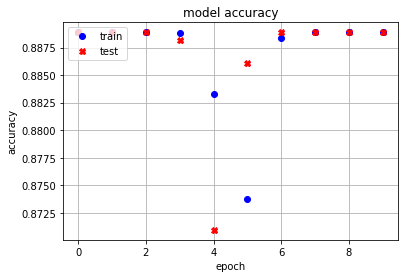

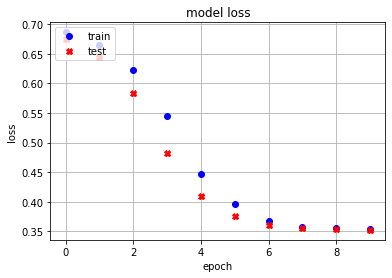

In [105]:
history, winner = playTwoPlayers(
    AIBestDecision.Singleton(1, "Best decision"),
    AI_Reinforcement_Random(2, "Reforce")
)

In [106]:
# plot_model(AIBestDecision.network, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# Image("model_plot.png")

In [107]:
# table = np.matrix([0], dtype=np.int32)
result = np.matrix([[1,0,0],[1,0,0],[2,2,0]])
result = np.matrix([[0,0,0],[0,0,0],[0,0,0]])

predict = AIBestDecision.Singleton().network.predict(np.array(result).reshape((1, 3, 3))).reshape((3, 3))
print(predict)


[[0.10753221 0.12551257 0.09413557]
 [0.11746673 0.10724721 0.10390761]
 [0.10912418 0.13827781 0.09679611]]


now, with the logic done we can make a network of keras

In [108]:
history, winner = playTwoPlayers(
    AIBestDecision.Singleton(1, "Best decision"),
    AI_Reinforcement_Random(2, "Reforce")
)
print(history, winner)

<tf.Variable 'Variable_2033:0' shape=(10, 3, 3) dtype=int32> -1


# 3. Now we look at the performance of best decision model

20/200 games
40/200 games
60/200 games
80/200 games
100/200 games
120/200 games
140/200 games
160/200 games
180/200 games


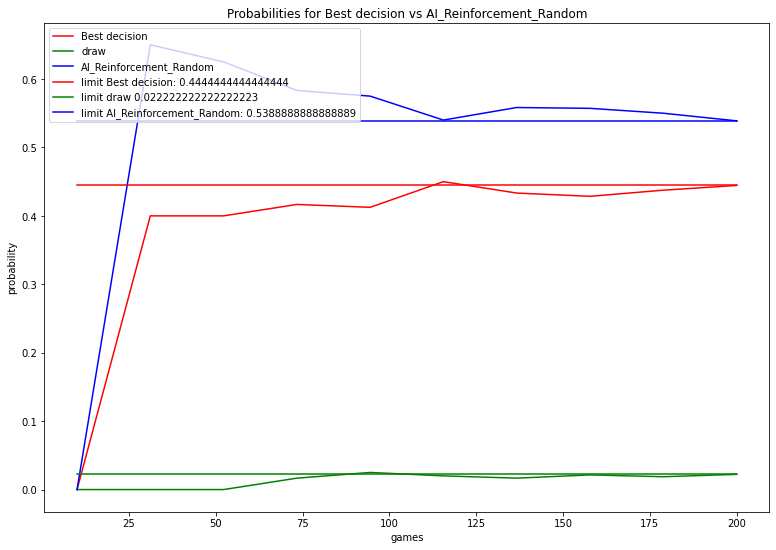

In [109]:
createPlot(
    lambda: playTwoPlayers(
        AIBestDecision.Singleton(1, "Best decision"),
        AI_Reinforcement_Random(2, "AI_Reinforcement_Random")
    ),
    "Best decision",
    "AI_Reinforcement_Random",
    redirect=sys.stdout,
    num_of_games=200
)

51% Best decision - 5% draw - 37% AI_reinforcement


In [110]:
history, winner = playTwoPlayers(
    AIBestDecision.Singleton(1, "Best decision 1"),
    AIBestDecision.Singleton(2, "Best decision 2")
)
print(history)

<tf.Variable 'Variable_2234:0' shape=(10, 3, 3) dtype=int32>


12/120 games
24/120 games
36/120 games
48/120 games
60/120 games
72/120 games
84/120 games
96/120 games
108/120 games


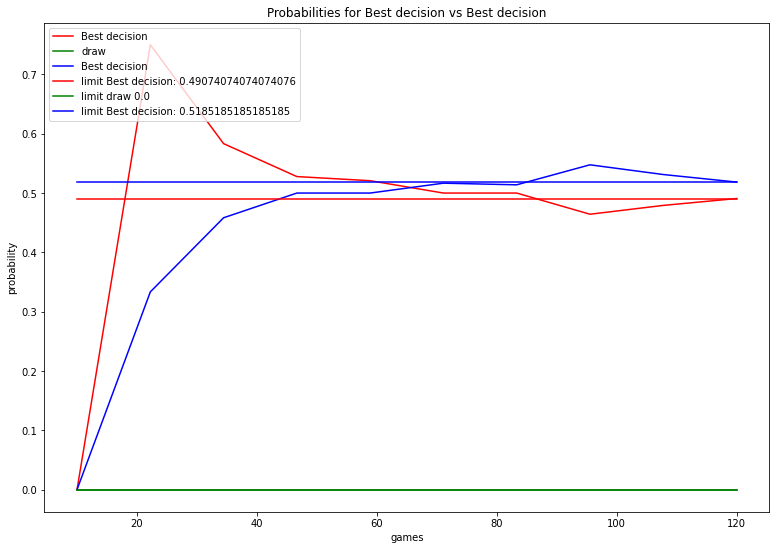

In [111]:
createPlot(
    lambda: playTwoPlayers(
        AIBestDecision.Singleton(1, "Best decision1"),
        AIBestDecision.Singleton(2, "Best decision2"),
    ),
   "Best decision",
    "Best decision",
    redirect=sys.stdout,
    num_of_games=120
)


best decision model cant beat himself, what should get it is a plot with all draws. This in addition of the previus plot, tells us that best decision model prevent draws. Because the model is smart, would tend to tie

In [112]:
try:
    history, winner = playTwoPlayers(
        Player,
        AIBestDecision.Singleton,
        "Me",
        "Best decision",
        allowDebug=True
    )
except:
    print("input error")
    

input error


Now, i will build an agent

In [113]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

# import tensorflow as tf

from tensorflow import keras
from keras import layers

from keras import losses, metrics, optimizers

from tensorflow.keras.optimizers import Adam 
from keras.models import Sequential
from keras.layers import MaxPooling2D, \
    Dropout, \
    Dense, \
    Flatten, \
    InputLayer, \
    Convolution2D as Conv2D, \
    Reshape
from keras.utils.vis_utils import plot_model
# from tf_agents.agents import DdpgAgent

The next RL algorithm has a centralized policy and descentralized agent.
To be implemented:

In [114]:
# class AgentQLearning(AIBestDecision):
class AgentQLearning(AI_Reinforcement_Random):
    
    _agent_q_learning = None
    
    def __init__(self, idPlayer, name, tictactoe, build=True):
        super().__init__(idPlayer, name)
        self.tictactoe = tictactoe
        self.states = self.tictactoe.fields * self.tictactoe.cols
        self.actions = (self.tictactoe.action_space).n
        #self.actions =  [
        #    self.tictactoe.action_space[0].n,
        #    self.tictactoe.action_space[1].n
        #]
        
        self.policy = None
        self.memory = None
        self.agent= None
        self.model = None
        
        # if self.policy == None:
        # self.build_agent()
        if build:
            self.build_model()
            self.train()
            self.test()
    
    def Singleton(idPlayer: int = -1, name: str = "example", tictactoe= None):
        if AgentQLearning._agent_q_learning == None:
            AgentQLearning._agent_q_learning = AgentQLearning(idPlayer, name, tictactoe)

        agent = AgentQLearning(
            idPlayer,
            name,
            tictactoe,
            build = False
        )

        agent.model = AgentQLearning._agent_q_learning.model
        agent.agent = AgentQLearning._agent_q_learning.agent
        
        return agent
    
    def build_model(self):
        self.model = Sequential()
        
        #self.model.add(Dense(2, input_shape=(1, 2), activation='relu'))
        #self.model.add(Flatten(input_shape=(1, 9)))
        
        self.model.add(InputLayer(input_shape=(1, 9)))
        self.model.add(Flatten())
        
        #self.model.add(Dense(10, activation='relu'))
        #self.model.add(Dense(10, activation='relu'))
        #self.model.add(Dense(10, activation='relu'))

        self.model.add(Flatten())
        # self.model.add(Reshape((1, 142)))
        self.model.add(Dense(9, activation='softwmax'))
        
        self.model.summary()

    def train(self):
        self.build_agent(
            self.model,
            self.states
        )
        
        self.agent.compile(
            Adam(
                learning_rate=0.0001
            ),
            metrics=['mae']
        )
        self.agent.fit(
            self.tictactoe,
            nb_steps=10,
            visualize=True,
            verbose=1
            #input_shape=(3,3)
        )
        
    def test(self):
        #scores = self.dqn.test(self.tictactoe, nb_episodes=20, visualize=True)
        #print(np.mean(scores.history['episode_reward']))
        pass
    
    def build_agent(self, model, actions):
        self.policy = BoltzmannQPolicy()
        self.memory = SequentialMemory(
            limit=50000,
            window_length=1
        )
        
        self.agent = DQNAgent(
            model=model,
            memory=self.memory,
            policy=self.policy,
            nb_actions=actions,
            nb_steps_warmup=100,
            target_model_update=1e-2
        )
    
    def play(self, players, tictactoe):
        table = tictactoe.table.copy()
        action = (0, 0)
        probToWin = 0
        
        # adapt the table to the train data
        if self.idPlayer != 1:
            table = self.swap_id_player_in_table(table, self.idPlayer, 1)
            
        action_predict = self.agent.forward(
            np.array(table).reshape((1 , self.actions)).tolist()[0]
        )
            
        # print(action_predict)
                        
        n_state, reward, done, info = tictactoe.step(action_predict)
        
        self.save(n_state, reward, done, info)
        

In [115]:
print()

In [116]:
#try:
tictactoe = TicTacToe(2, np.zeros((3, 3), np.int32), 3, False)

history, winner = playTwoPlayers(
    AgentQLearning.Singleton(1, "AgentQLearning", tictactoe),
    AI_Reinforcement_Random(2, "AI_Reinforcement_Random"),
    tictactoe=tictactoe,
    allowDebug=True,
)
# except:
#    print("error")

ValueError: Unknown activation function: softwmax. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
tictactoe = TicTacToe(2, np.zeros((3, 3), np.int32), 3, False)
createPlot(
    lambda: playTwoPlayers(
        AgentQLearning.Singleton(1, "AgentQLearning", tictactoe),
        AI_Reinforcement_Random(2, "AI_Reinforcement_Random"),
        tictactoe=tictactoe,
        allowDebug=False
    ),
    "AgentQLearning",
    "AI_Reinforcement_Random",
    redirect=sys.stdout,
    num_of_games=200
)